In [3]:
import os, time
from pathlib import Path
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

from unet import build_unet
from utils import create_dir, seeding, sort_path_list



def calculate_metrics(y_true, y_pred,threshold):
    # Ground truth
    y_true = y_true.cpu().numpy()
    y_true = y_true > threshold
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    # Prediction
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > threshold
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":
    
    threshold=0.8
    # Seeding
    seeding(42)

    # Directories
    base_path = Path.cwd().parent
    create_dir(base_path / "results")

    # Load dataset
    test_x = list((base_path / "new_data/test/images/").glob("*.jpeg"))
    test_y = list((base_path / "new_data/test/masks/").glob("*.jpeg"))
    
    test_x.sort(key=sort_path_list)
    test_y.sort(key=sort_path_list)

    # Hyperparameters
    H = 128
    W = 128
    size = (W, H)
    checkpoint_path = base_path / "models/roof_surface_model_B40_E10_lr1.000e-03_L4_Adam_DiceBCE.pth"

    # Load checkpoint
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []
    pred_y_plot=[]
    img_plot=[]
    mask_plot=[]

    for i, (x_file, y_file) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        # Extract the name
        x_filename = x_file.stem
        y_filename = y_file.stem

        """ Reading image """
        image = cv2.imread(str(x_file), cv2.IMREAD_COLOR) ## (512, 512, 3)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)


        """ Reading mask """
        mask = cv2.imread(str(y_file), cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y, threshold)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)
            #for ploting

            pred_y_plot.append(pred_y)
            img_plot.append(image)
            
            
            pred_y = pred_y > threshold
            pred_y = np.array(pred_y, dtype=np.uint8)



        """ Saving masks """
        ori_mask = mask_parse(mask)
        
        mask_plot.append(ori_mask)
        
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128
        
        
        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        
        #cv2.imwrite(f"results/{x_filename}.png", cat_images)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)


100%|█████████████████████████████████████████| 406/406 [00:13<00:00, 30.14it/s]

Jaccard: 0.6006 - F1: 0.7385 - Recall: 0.7944 - Precision: 0.7130 - Acc: 0.9372
FPS:  104.39109906205476


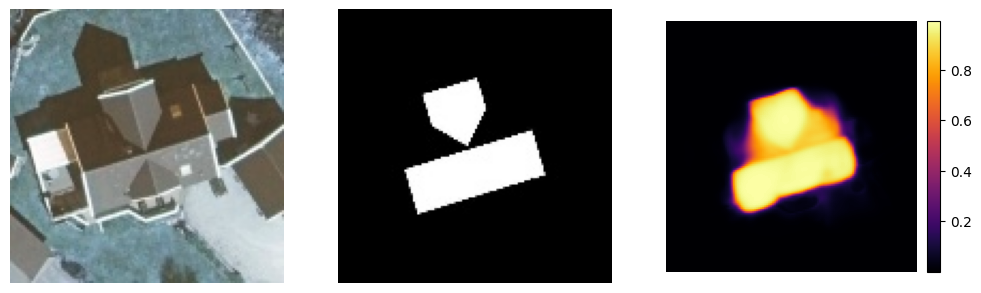

In [84]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


idx=100
fig, ax = plt.subplots(1, 3, figsize = (12, 12))

ax[0].imshow(img_plot[idx])
ax[0].axis("off")
ax[1].imshow(mask_plot[idx])
ax[1].axis("off")
ax[2].imshow(pred_y_plot[idx])
ax[2].axis("off")
divider = make_axes_locatable(ax[2])
cax2 = divider.append_axes("right", size="5%", pad=0.1)
cb=plt.colorbar(ax[2].imshow(pred_y_plot[idx],cmap = mpl.cm.inferno),cax=cax2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


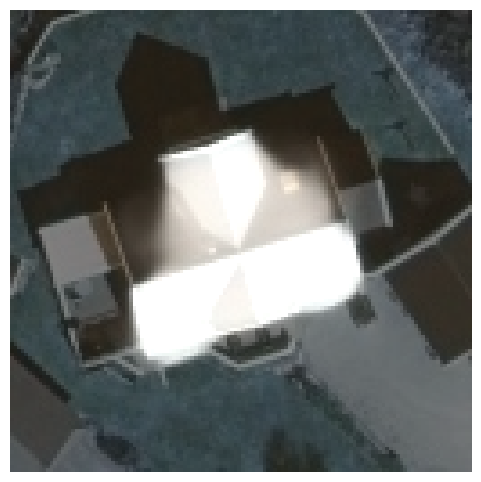

In [108]:
from skimage import img_as_float
from skimage.color import gray2rgb, rgb2gray
from skimage import io
blend = 0.5 * img_as_float(img_plot[idx]) + 0.8 * gray2rgb(img_as_float((pred_y_plot[idx])))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.imshow(blend)
ax.axis("off")
plt.show()


In [128]:
import rasterio
from rasterio import features
import shapely
from shapely.geometry import Point, Polygon

pred_y_mask = pred_y_plot[idx] > threshold
pred_y_mask = np.array(pred_y_mask, dtype=np.uint8)
pred_y_mask = mask_parse(pred_y_mask)
pred_y_mask=pred_y_mask*255

def mask_to_polygons_layer(mask):
    all_polygons = []
    for shape, value in features.shapes(mask.astype(np.int16), mask=(mask >0), transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0)):
        #return shapely.geometry.shape(shape)
        all_polygons.append(shapely.geometry.shape(shape))

    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = shapely.geometry.MultiPolygon([all_polygons])
    return all_polygons

polygons = mask_to_polygons_layer(pred_y_plot[idx]>threshold)

In [287]:
from skimage.draw import line
def draw_surface(img_org,xx,yy):
    xx,yy = np.asarray(xx,int), np.asarray(yy,int)
    if len(polygons)!=1:
        for j in range(len(polygons)):
            for i in range(len(polygons[j])-1):
                rr, cc = line(polygons[j][i][0],polygons[j][i][1],polygons[j][i+1][0],polygons[j][i+1][1])
                img_org[rr, cc] = (255, 0, 0)
                img_org[rr+1, cc+1] = (255, 0, 0)
    else:
        for i in range(len(xx)-1):
            x1=xx[i]
            y1=yy[i]
            x2=xx[i+1]
            y2=yy[i+1]
            print(x1)
            #rr, cc = line(xx[i],yy[i],xx[i+1],yy[i+1])
            #print(rr,cc)
            rr, cc = line(x1,y1,x2,y2)
            print(type(cc[1]))
            print(rr,cc)
            print(isinstance((rr,cc), tuple))
            img_org[rr, cc] = (255, 0, 0)
            #img_org[rr+1, cc+1] = (255, 0, 0)
            #img_org[rr-1, cc-1] = (255, 0, 0)
    return img_org

In [289]:
img=draw_surface(img_plot,xx,yy)
io.imshow(img)
io.show

60
<class 'numpy.int64'>
[60 61 62 63 64 65 66 67] [36 36 36 36 36 36 36 36]
True


/tmp/ipykernel_27597/967570334.py:4: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(polygons)!=1:


TypeError: only size-1 arrays can be converted to Python scalars